# Imports

## Toy Experiment Imports

In [199]:
from pathlib import Path
import importlib
import env
import utils
importlib.reload(env)
importlib.reload(utils)

setup_data_path = Path().resolve() / 'setup_data'

## Langchain Imports

In [200]:
from dotenv import load_dotenv
load_dotenv()
import os
import openai
from typing import List, Type, Optional, Annotated, Sequence, Literal, TypedDict
from typing_extensions import TypedDict
from pydantic import BaseModel, create_model, field_validator, Field
from langchain_core.tools import BaseTool
from langchain_core.callbacks import CallbackManagerForToolRun, AsyncCallbackManagerForToolRun
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, ToolMessage, BaseMessage, HumanMessage
from langgraph.prebuilt import ToolNode, InjectedState # Good docs / source code https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langworkflow/prebuilt/tool_node.py
from langgraph.graph import StateGraph, START, END
import operator
import functools
from copy import deepcopy

OPENAI_KEY = os.getenv('OPENAI_API_KEY')

# Definitions
## Toy Experiment Definitions

In [201]:
envs = utils.load_envs(setup_data_path, 'Version_0')

In [202]:
RUN_ENV = envs[0]

## Lang-graph Definitions

In [203]:
# Tool Definition

class AgentsInterface(BaseTool):
    name: str = "AgentsInterface"
    description: str = "How you instruct the agents to follow a particular path. All agents should recieve a path according to the argument description in this singular tool call."
    args_schema: Type[BaseModel] = RUN_ENV.generate_env_tool() # ALTER THIS
    return_direct: bool = True
        
        
    def _run(
        self, **kwargs
    ) -> str:
        """Use the tool."""
        # The "$xtra" prefix on a kwarg means it isn't an agent path and serves another purpose
        # Ok i was wrong about the $xtra stuff bc it would have to go through the pydantic interface which would make it an arg for the LLM
        # What i will do it somehow set the env value in the state, and then pass the state to the tool
        # IDk man check this out https://langchain-ai.github.io/langgraph/how-tos/pass-run-time-values-to-tools/#define-the-tools
        # Might not work, good luck!!
        print(kwargs)

        agent_paths = {k : [(p.x, p.y, p.z)for p in v] for k, v in kwargs.items() if k != 'env'} # Converts point object to tuple
        print(agent_paths)
        print(kwargs.get('env', 'noenv'))
        run_env : env.env = kwargs.get('env')
        plan, feedback, has_feedback = run_env.tool_call_backend(agent_paths)
        print(f'Plan: {plan}')
        print(f'Feedback: {feedback}')
        print(f'Has Feedback: {has_feedback}')

        
        return run_env.prompt(method = 'default', feedback_plan = feedback)[2] if has_feedback else 'Success!'

In [204]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Plan paths for agents to navigate a 3D grid to reach their respective goals and avoid collision."
                " You are given:"
                " 1) a list of obstacle coordinates (x, y, z): locations of the obstacle grid cells, agents must avoid them."
                " 2) a list of [([name], [init], [goal]) tuples], [init] and [goal] are 3D coordinates of the initial position and goal position of agent named [name]."
                " 3) a previous plan, if any, and why it failed. Analyze this information and re-plan a collision-free path."
                " How to plan a <path>:"
                " 1) Make sure each path does not touch any obstacle or another agent."
                " 2) Create a set of points for each agent to go from their init coordinates to their goal coordinates."
                " 3) Make sure the coordinates are exactly one step away from each other, in one direction. Note - you may only move in one direction at a time."
                " Example of a <path>: [{{'x' : 1, 'y' : 1, 'z' : 1}}, {{'x' : 1, 'y' : 1, 'z' : 2}}, {{'x' : 1, 'y' : 1, 'z' : 3}},...]"
                " Output Instruction: Use the Agent Interface tool provided to output your final plan for the agents. \n{system_message}"
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [205]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    inference_count: int
    env : env.env

In [206]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), sender=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


def no_tool(state):
    msg = HumanMessage(content='No tool call found - make sure the tool interfaces are used as properly described.')
    return {
        'messages' : [msg],
        'sender' : 'human'
    }


def gen_tool_node(state, tools):
        result = []
        tools_by_name = {tool.name: tool for tool in tools}
        for tool_call in state["messages"][-1].tool_calls:
            tool = tools_by_name[tool_call["name"]]
            call = deepcopy(tool_call)
            if tool_call['name'] == 'AgentsInterface':
                call['args']['env'] = state['env']
            observation = tool.invoke(call["args"])
            result.append(ToolMessage(content=observation, sender=call['name'], tool_call_id=call["id"]))
            print('appended1')
        return {"messages": result}

In [207]:
# Define Agents & Nodes

llm = ChatOpenAI(model='gpt-4o-mini')


tools = [AgentsInterface()]
tool_node = functools.partial(gen_tool_node, tools=tools)

# Main agent & node
agent1 = create_agent(
    llm, 
    tools,
    system_message=""
)

agent1_node = functools.partial(agent_node, agent=agent1, name='agent1')

# Tool node


'gpt-4o-mini'

In [208]:
def router(state) -> Literal['call_tool', '__end__', 'continue']:
    messages = state['messages']
    last_message = messages[-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return 'call_tool'
    # You're normally supposed to add some condition to end and otherwise continue, but this is just for testing
    elif last_message.sender == 'AgentsInterface' and 'success' in last_message.content.lower():
        print('ending_code')
        return '__end__'
    else:
        return 'continue'

In [215]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

workflow = StateGraph(State)

workflow.add_node('agent1', agent1_node)
workflow.add_node('call_tool', tool_node)
workflow.add_node('no_tool', no_tool)

workflow.add_conditional_edges(
    'agent1',
    router,
    {'continue' : 'no_tool','call_tool' : 'call_tool'}
)

workflow.add_edge('no_tool', 'agent1')

workflow.add_conditional_edges(
    'call_tool',
    router,
    {'continue' : 'agent1', '__end__' : END}
)

workflow.add_edge(START, 'agent1')

graph = workflow.compile(checkpointer=checkpointer)

In [234]:



from PIL import Image
import io

image_bytes = graph.get_graph().draw_mermaid_png()  
image_stream = io.BytesIO(image_bytes)
image = Image.open(image_stream)
image.save('output.png', 'PNG')
image_stream.close()

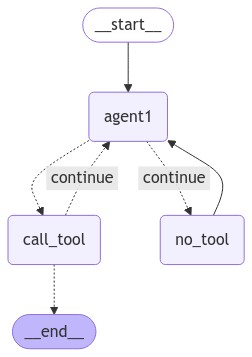

In [216]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [218]:
msg = HumanMessage(
    content=RUN_ENV.prompt(method='default')[1],
)
config = {'configurable' : {'thread_id' : '1', 'recursion_limit' : 5}}


events = graph.stream({'messages' : [msg], 'env' : RUN_ENV}, config)
evs = []
for s in events:
    print(s)
    evs.append(s)

{'agent1': {'messages': [AIMessage(content='To plan collision-free paths for the agents in a 3D grid while avoiding obstacles, we will analyze the initial and goal positions of each agent and the locations of obstacles. We will ensure that each agent\'s path consists of valid moves that do not overlap with obstacles or with other agents’ paths.\n\n### Step-by-Step Analysis:\n\n1. **Grid Size**: 10 x 10 x 10\n2. **Obstacles**: \n   - (5, 9, 10)\n   - (10, 3, 10)\n   - (4, 7, 9)\n   - (7, 6, 2)\n   - (9, 3, 9)\n   - (10, 7, 9)\n   - (5, 7, 7)\n   - (7, 3, 9)\n   - (6, 3, 10)\n   - (4, 8, 8)\n\n3. **Agents and Goals**:\n   - **Agent Alice**: \n     - Init: (9, 3, 2)\n     - Goal: (6, 1, 3)\n   - **Agent Bob**: \n     - Init: (2, 6, 4)\n     - Goal: (4, 3, 9)\n   - **Agent Chad**: \n     - Init: (1, 10, 3)\n     - Goal: (3, 1, 5)\n   - **Agent Dave**: \n     - Init: (1, 4, 2)\n     - Goal: (6, 8, 9)\n\n### Path Planning:\n\n**Path for Agent Alice**:\n- Start at (9, 3, 2) and must reach (6,

TypeError: Object of type env is not serializable

In [235]:
msg.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
 'kwargs': {'content': 'At the current step: Grid size: 10 x 10 x 10\nObstacles: (5, 9, 10) (10, 3, 10) (4, 7, 9) (7, 6, 2) (9, 3, 9) (10, 7, 9) (5, 7, 7) (7, 3, 9) (6, 3, 10) (4, 8, 8)\nAgent Alice init: (9, 3, 2) goal: (6, 1, 3)\nAgent Bob init: (2, 6, 4) goal: (4, 3, 9)\nAgent Chad init: (1, 10, 3) goal: (3, 1, 5)\nAgent Dave init: (1, 4, 2) goal: (6, 8, 9)\nYour reasoning and plan is',
  'type': 'human'}}

TypeError: 'generator' object is not callable

In [228]:
vis_plan = {'Alice': [(9, 3, 2), (9, 3, 3), (9, 3, 4), (9, 2, 4), (8, 2, 4), (7, 2, 4), (6, 2, 4), (6, 1, 4), (6, 1, 3)], 'Bob': [(2, 6, 4), (2, 5, 4), (2, 4, 4), (2, 3, 4), (3, 3, 4), (4, 3, 4), (4, 3, 5), (4, 3, 6), (4, 3, 7), (4, 3, 8), (4, 3, 9)], 'Chad': [(1, 10, 3), (1, 9, 3), (1, 8, 3), (1, 7, 3), (1, 6, 3), (1, 5, 3), (1, 4, 3), (1, 3, 3), (1, 2, 3), (2, 2, 3), (3, 2, 3), (3, 1, 3), (3, 1, 4), (3, 1, 5)], 'Dave': [(1, 4, 2), (2, 4, 2), (3, 4, 2), (4, 4, 2), (5, 4, 2), (6, 4, 2), (6, 5, 2), (6, 6, 2), (6, 7, 2), (6, 8, 2), (6, 8, 3), (6, 8, 4), (6, 8, 5), (6, 8, 6), (6, 8, 7), (6, 8, 8), (6, 8, 9)]}
envs[0].visualize(agent_plan=vis_plan)

In [124]:
evs[0]['agent1']['messages'][0].tool_calls

[{'name': 'AgentsInterface',
  'args': {'Alice': [{'x': 9, 'y': 3, 'z': 2},
    {'x': 8, 'y': 3, 'z': 2},
    {'x': 7, 'y': 3, 'z': 2},
    {'x': 6, 'y': 3, 'z': 2},
    {'x': 6, 'y': 2, 'z': 2},
    {'x': 6, 'y': 1, 'z': 2},
    {'x': 6, 'y': 1, 'z': 3}]},
  'id': 'call_apc0UD3Aq43XAcL3xOfn3VwO',
  'type': 'tool_call'},
 {'name': 'AgentsInterface',
  'args': {'Bob': [{'x': 2, 'y': 6, 'z': 4},
    {'x': 3, 'y': 6, 'z': 4},
    {'x': 4, 'y': 6, 'z': 4},
    {'x': 4, 'y': 5, 'z': 4},
    {'x': 4, 'y': 4, 'z': 4},
    {'x': 4, 'y': 3, 'z': 4},
    {'x': 4, 'y': 3, 'z': 5},
    {'x': 4, 'y': 3, 'z': 6},
    {'x': 4, 'y': 3, 'z': 7},
    {'x': 4, 'y': 3, 'z': 8},
    {'x': 4, 'y': 3, 'z': 9}]},
  'id': 'call_L0z4BsvcfRxdm50Ia4N2f7eW',
  'type': 'tool_call'},
 {'name': 'AgentsInterface',
  'args': {'Chad': [{'x': 1, 'y': 10, 'z': 3},
    {'x': 1, 'y': 9, 'z': 3},
    {'x': 1, 'y': 8, 'z': 3},
    {'x': 1, 'y': 7, 'z': 3},
    {'x': 1, 'y': 6, 'z': 3},
    {'x': 1, 'y': 5, 'z': 3},
    {'x': 